# Real Estate Price Valuation
Autor: [Jakub Stępkowski](https://github.com/stepkos/)

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from pathlib import Path
import os

In [2]:
out_plots_path = Path(os.getcwd()).parent / "out" / "plots"

## Badanie danych i wstępne przetwarzanie danych

### Wczytujemy dane z pliku CSV

In [3]:
data = pd.read_csv('./../data/apartments-wroclaw.csv', delimiter=';')

### Sprawdzamy poprawność wczytanych danych i zapoznajemy się z ich strukturą

In [4]:
print(data)
print(data.columns)

                                                  title  \
0              okazja apartament mieszkanie dwupokojowe   
1     3 pokojowe mieszkanie na sprzedaż/ kredyt #naS...   
2       Słoneczny apartament, miejsce postojowe w cenie   
3      3-pokojowe mieszkanie 66m2 + balkon Bezpośrednio   
4                   2-pokojowe mieszkanie 41m2 + balkon   
...                                                 ...   
9839              3-pokojowe mieszkanie w samym centrum   
9840  Promocja l 2 pokoje na Lipie Piotrowskiej l Ba...   
9841                Klimatyczne mieszkanie w kamienicy.   
9842           Gotowe 3 pokoje z ogródkiem na Zakrzowie   
9843            4-pokojowe mieszkanie 101m2 + 2 balkony   

                                                address      price  rooms  \
0            Gajowice, Fabryczna, Wrocław, dolnośląskie   569000.0      2   
1     ul. Eugeniusza Horbaczewskiego, Gądów, Fabrycz...   750000.0      3   
2     ul. Babiego Lata, Krzyki, Krzyki, Wrocław, dol...   86

### Z adresu wybieramy osiedle

In [5]:
data['address_estate'] = data['address'].apply(lambda x: x.split(', ')[-3])
print(pd.unique(data['address_estate']))
print(data['address_estate'].isna().sum())


['Fabryczna' 'Krzyki' 'Śródmieście' 'Psie Pole' 'Stare Miasto'
 'Kobierzyce' 'Siechnice' 'Miękinia' 'Długołęka' 'Kąty Wrocławskie']
0


### Wypisujemy unikalne wartości dla każdej kolumny
- Chcemy wiedzieć czy nie wystąpiły błędy przy wczytaniu wartości
- Chcemy obsłużyć przypadki szczególnych wartości
- Chcemy wiedzieć które dane będziemy chcieli mapować na wartości liczbowe, a które na kategorie

In [6]:
# stwórzmy w tym celu funkcję będziemy ją dalej wykorzystywać
def print_unique(data: pd.DataFrame):
  for col in data.columns:
    print(col, pd.unique(data[col]))

print_unique(data)

title ['okazja apartament mieszkanie dwupokojowe'
 '3 pokojowe mieszkanie na sprzedaż/ kredyt #naStart'
 'Słoneczny apartament, miejsce postojowe w cenie' ...
 '3-pokojowe mieszkanie w samym centrum'
 'Klimatyczne mieszkanie w kamienicy.'
 'Gotowe 3 pokoje z ogródkiem na Zakrzowie']
address ['Gajowice, Fabryczna, Wrocław, dolnośląskie'
 'ul. Eugeniusza Horbaczewskiego, Gądów, Fabryczna, Wrocław, dolnośląskie'
 'ul. Babiego Lata, Krzyki, Krzyki, Wrocław, dolnośląskie' ...
 'ul. Racławicka 100, Grabiszynek, Fabryczna, Wrocław, dolnośląskie'
 'Strawińskiego, Jagodno, Krzyki, Wrocław, dolnośląskie'
 'Al. Władysława Sikorskiego, Szczepin, Stare Miasto, Wrocław, dolnośląskie']
price [ 569000.  750000.  865000. ... 1595712.  549670. 1260861.]
rooms [ 2  3  4  5  1  6  8 10 11  7  9]
area [39.19 63.6  50.   ... 88.8  61.16 83.11]
floor ['2' '4' '3' '1' '5' '10' 'parter' '10+' '6' '9' '8' '0' '7' 'suterena'
 nan 'poddasze' '11']
max_floor [ 7. 11.  4.  2. 10.  5.  1.  3.  8.  6. 17.  9. nan 16.

### Sprawdzmy ile razy wartość null występuje w konkretnych kolumnach
Zwizualizujmy to na wykresie

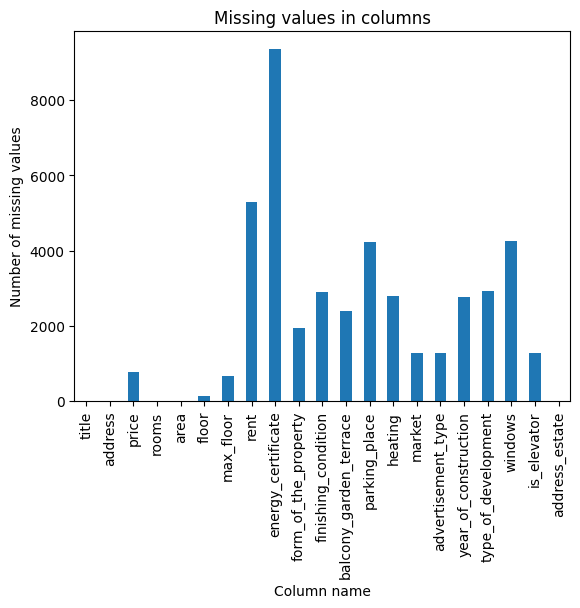

In [7]:
data.isna().sum().plot(
    kind='bar',
    title='Missing values in columns',
    xlabel='Column name',
    ylabel='Number of missing values'
)
plt.savefig(out_plots_path / 'missing_values.png', bbox_inches='tight')

### Podejmujemy decyzje, które atrybuty wstępnie chcemy wziąc pod uwagę

In [8]:
target = 'price'
features = [
    'rooms',
    'area',
    'address_estate',
    'floor',
    'max_floor',
    'market',
    'year_of_construction',
    'finishing_condition',
    'is_elevator'
]
features_and_target = features + [target]

### Wybieramy interesujące nas kolumny oraz usuwamy wartości null

In [9]:
data_cleaned = data[features_and_target]
for feature in features_and_target:
  data_cleaned = data_cleaned[~data_cleaned[feature].isna()]

print(data_cleaned.shape)

(4571, 10)


### Obłsugujemy wartości szczególne

In [10]:
print(data_cleaned[data_cleaned['floor'] == 'suterana'].shape)
print(data_cleaned[data_cleaned['floor'] == 'poddasze'].shape)

(0, 10)
(2, 10)


Z pozostałych mieszkań, żadne nie ma wartości "suterena", dla kolumny floor,
a wartość "poddasze" posiada tylko 2 mieszkania. W tym przypadku usuwamy te dane.
Unuśmy równie rekordy z wartością "suterena" na wypadek jakby dane się zmieniły.

Niech "parter" będzie tożsamy z 0,
a "10+" częścią całkowitą z wysokości bloku (max_floor).

In [11]:
data_cleaned = data_cleaned[data_cleaned['floor'] != 'suterena']
data_cleaned = data_cleaned[data_cleaned['floor'] != 'poddasze']
data_cleaned['floor'] = data_cleaned['floor'].replace('parter', '0')
data_cleaned['floor'] = data_cleaned.apply(
    lambda row: row['max_floor'] // 2 if row['floor'] == '10+' else row['floor'], axis=1
)
data_cleaned['floor'] = data_cleaned['floor'].astype(int)
data_cleaned['max_floor'] = data_cleaned['max_floor'].astype(int)
data_cleaned['year_of_construction'] = data_cleaned['year_of_construction'].astype(int)

In [12]:
print_unique(data_cleaned)
print("\nShape:", data_cleaned.shape)

rooms [ 2  3  4  5  1  6 10  8  7  9]
area [39.19 63.6  50.   ... 91.35 88.8  63.82]
address_estate ['Fabryczna' 'Krzyki' 'Śródmieście' 'Stare Miasto' 'Psie Pole'
 'Kobierzyce' 'Siechnice' 'Miękinia' 'Długołęka' 'Kąty Wrocławskie']
floor [ 2  4  3  0  5  1  6  9  7  8 10 24 11 26 25 14]
max_floor [ 7 11  4  5  3  6 10  2  8  9 18  1 23 48 16 17 14 12 15 13 22 20 52 19
 51 28]
market ['wtórny' 'pierwotny']
year_of_construction [ 2024  1980  2015  1902  1968  2008  2019  1890  2020  2022  1930  2016
  2025  1960  2014  1900  2001  1925  2023  1973  2012  2000  2013  1904
  2002  2011  1911  2017  2003  1985  2010  1963  1889  1965  2005  1905
  2021  2004  1971  1987  1962  1975  2006  1992  1988  1920  2018  1984
  1976  1957  1907  1993  1950  1888  1978  1990  1906  1964  1935  1991
  1981  1989  2009  1995  1970  2026  1982  1972  1959  1915  1999  1983
  1939  1997  2007  1961  1910  1899  1936  1898  1896  1940  1969  1979
  1933  1938  1937  1994  1986  1956  1914  1901  1967  192

### Mapujemy wartości tekstowe na obiekty kategorii


In [13]:
data_cleaned['address_estate'] = data_cleaned['address_estate'].astype('category')
data_cleaned['market'] = data_cleaned['market'].astype('category')
data_cleaned['finishing_condition'] = data_cleaned['finishing_condition'].astype('category')
data_cleaned['is_elevator'] = data_cleaned['is_elevator'].astype('category')

### Sprawdźmy średnie ceny wg osiedli

In [75]:
def print_histograms(data: pd.DataFrame, features: list, figsize=(10, 20)):
    # Utworzenie układu wielu wykresów
    fig, axes = plt.subplots(
        # nrows=(len(features) + 2) // 3, ncols=3, figsize=figsize
        nrows=(len(features) + 1) // 2, ncols=2, figsize=figsize
    )

    # Wypłaszczenie dla łatwiej iteracji
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]
        if data[feature].dtype.name == 'category':
            data[feature].value_counts().plot(kind='bar', ax=ax)
            ax.set_title(f'Bar Plot of {feature}')
        else:
            data[feature].plot(kind='hist', bins=15, ax=ax)
            ax.set_title(f'Histogram of {feature}')

        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')

    # Usunięcie pustych subplotów, jeśli istnieją
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Dopasowanie i wyświetlenie wykresów
    plt.tight_layout()


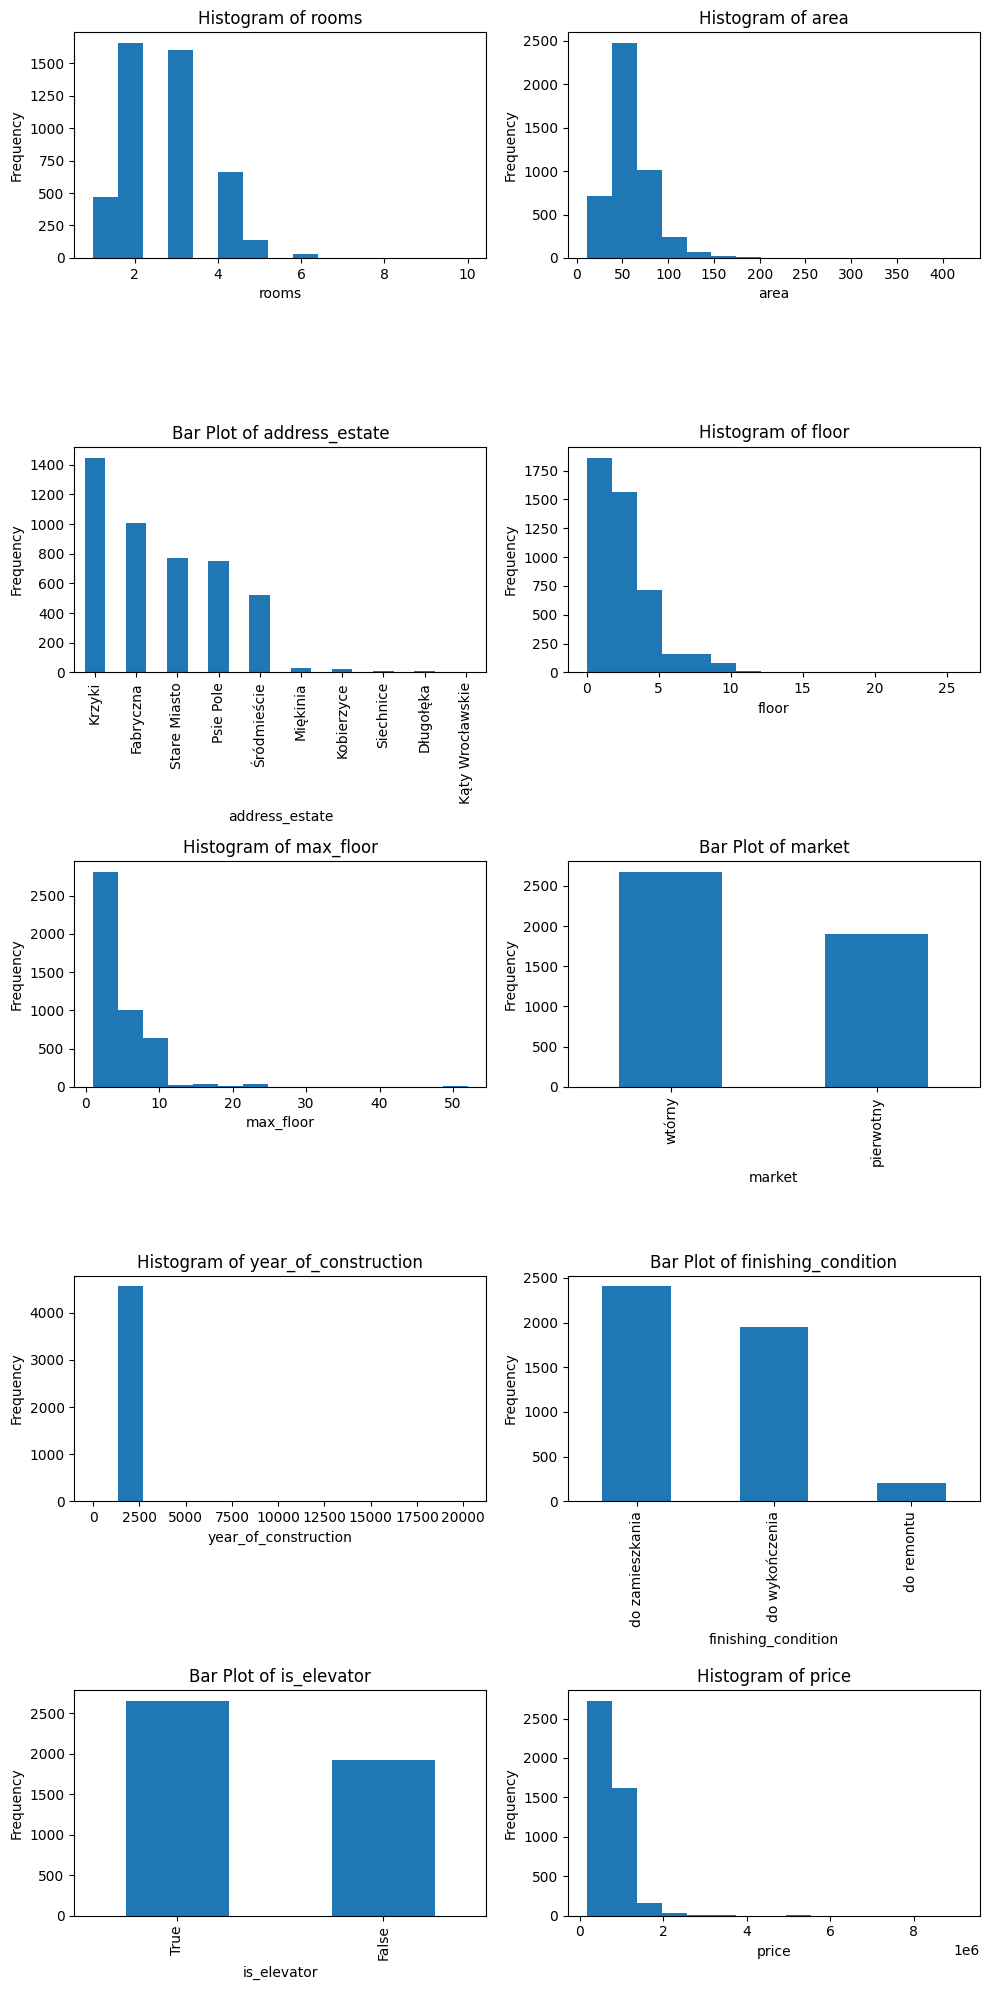

In [76]:
print_histograms(data_cleaned, features_and_target)
plt.savefig(out_plots_path / 'histograms.png', bbox_inches='tight')

In [61]:
print(data_cleaned["address_estate"].value_counts())

address_estate
Krzyki              1449
Fabryczna           1008
Stare Miasto         769
Psie Pole            750
Śródmieście          523
Miękinia              32
Kobierzyce            22
Siechnice              7
Długołęka              6
Kąty Wrocławskie       1
Name: count, dtype: int64


### Usuwamy skrajne wartości

In [62]:
data_cut = data_cleaned.copy()
data_cut = data_cut[data_cut['price'] < 2000000]
data_cut = data_cut[data_cut['year_of_construction'] > 1850]
data_cut = data_cut[data_cut['year_of_construction'] < 2030]
data_cut = data_cut[data_cut['max_floor'] < 30]
data_cut = data_cut[data_cut['area'] < 200]
data_cut = data_cut[data_cut['address_estate'] != "Kąty Wrocławskie"]
data_cut['address_estate'] = data_cut['address_estate'].cat.remove_categories(['Kąty Wrocławskie'])

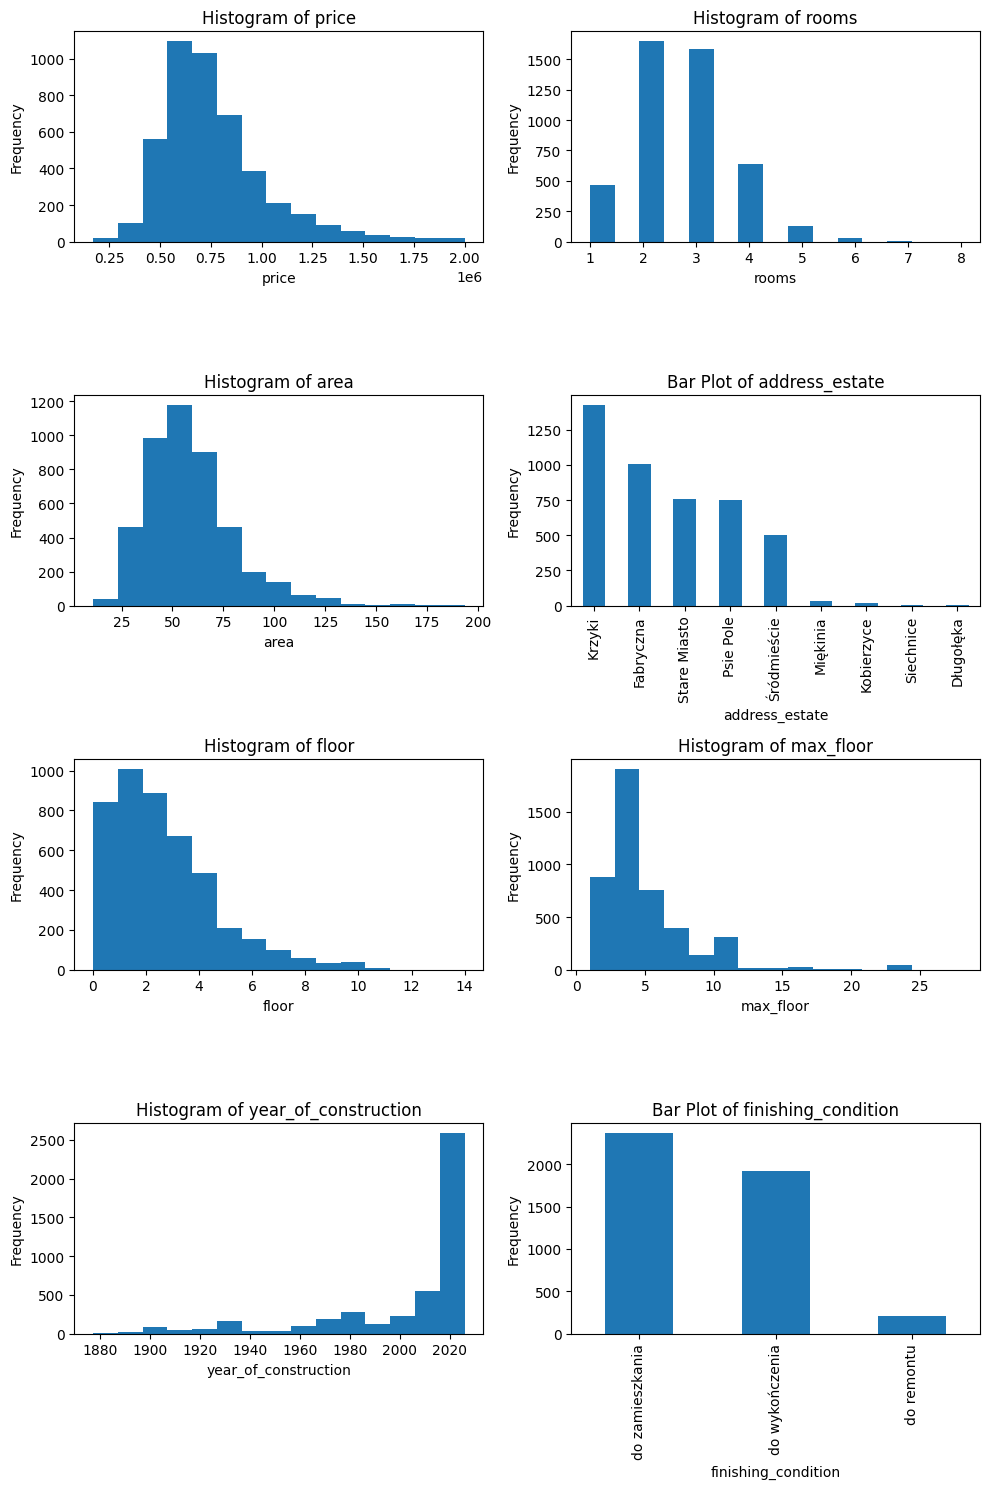

In [78]:
print_histograms(data_cut, [
    'price',
    'rooms',
    'area',
    'address_estate',
    'floor',
    'max_floor',
    'year_of_construction',
    'finishing_condition',
], figsize=(10, 15))
plt.savefig(out_plots_path / 'histograms_cut.png', bbox_inches='tight')

/var/folders/d8/bbvpllg90cbfkcp6nvf5yhp80000gn/T/ipykernel_91862/3953096804.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_prices = data_cut.groupby('address_estate')['price'].mean().reset_index()


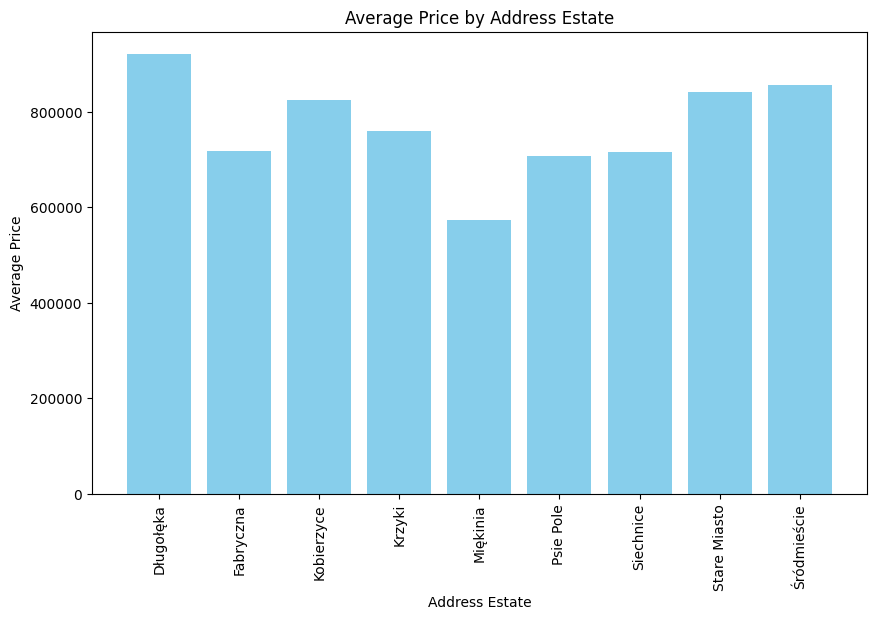

In [22]:
average_prices = data_cut.groupby('address_estate')['price'].mean().reset_index()

# Wykres słupkowy średnich cen
plt.figure(figsize=(10, 6))
plt.bar(average_prices['address_estate'], average_prices['price'], color='skyblue')
plt.xlabel('Address Estate')
plt.ylabel('Average Price')
plt.title('Average Price by Address Estate')
plt.xticks(rotation=90)
plt.savefig(out_plots_path / 'average_price_by_estate.png', bbox_inches='tight')

In [23]:
print(data_cut.shape)

(4496, 10)


### Chcemy zobaczyć rozkład ceny w zalezności od wykończenia

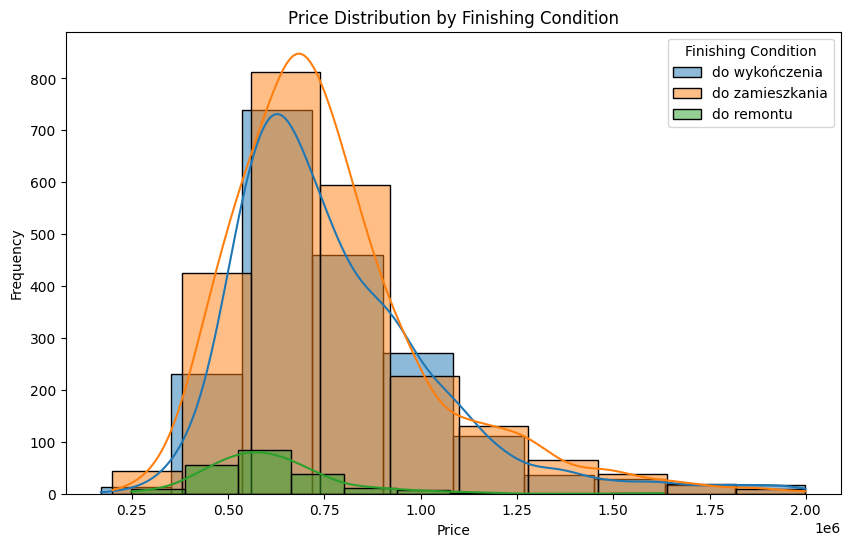

In [24]:
import seaborn as sns


conditions = data_cut['finishing_condition'].unique()

# Tworzenie wykresów
plt.figure(figsize=(10, 6))
for condition in conditions:
    subset = data_cut[data_cut['finishing_condition'] == condition]
    sns.histplot(subset['price'], kde=True, label=condition, bins=10, alpha=0.5)

# Dodanie legendy i etykiet
plt.legend(title='Finishing Condition')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution by Finishing Condition')
plt.savefig(out_plots_path / 'price_distribution_by_fininshing_condition', bbox_inches='tight')

### Kategorie sprowadzamy do kodu kategorii

In [25]:
data_cat = data_cut.copy()
data_cat['address_estate'] = data_cat['address_estate'].cat.codes
data_cat['market'] = data_cat['market'].cat.codes
data_cat['finishing_condition'] = data_cat['finishing_condition'].cat.codes
data_cat['is_elevator'] = data_cat['is_elevator'].cat.codes

In [26]:
print_unique(data_cat)

rooms [2 3 4 5 1 6 8 7]
area [39.19 63.6  50.   ... 91.35 88.8  63.82]
address_estate [1 3 8 7 5 2 6 4 0]
floor [ 2  4  3  0  5  1  6  9  7  8 10 11 14]
max_floor [ 7 11  4  5  3  6 10  2  8  9 18  1 23 16 17 14 12 15 13 22 20 19 28]
market [1 0]
year_of_construction [2024 1980 2015 1902 1968 2008 2019 1890 2020 2022 1930 2016 2025 1960
 2014 1900 2001 1925 2023 1973 2012 2000 2013 1904 2002 2011 1911 2017
 2003 1985 2010 1963 1889 1965 2005 1905 2021 2004 1971 1987 1962 1975
 2006 1992 1988 1920 2018 1984 1976 1957 1907 1993 1950 1888 1978 1990
 1906 1964 1935 1991 1981 1989 2009 1995 1970 2026 1982 1972 1959 1915
 1999 1983 1997 2007 1961 1939 1910 1899 1936 1898 1896 1940 1969 1979
 1933 1938 1937 1994 1986 1956 1914 1901 1967 1927 1974 1926 1912 1966
 1934 1958 1977 1908 1998 1946 1932 1945 1996 1921 1929 1887 1918 1885
 1877 1947 1954 1928 1883 1923 1919 1903 1955 1893]
finishing_condition [1 2 0]
is_elevator [1 0]
price [ 569000.  750000.  865000. ...  805800.  610721. 1260861.]


### Wygenerujmy macierz korelacji

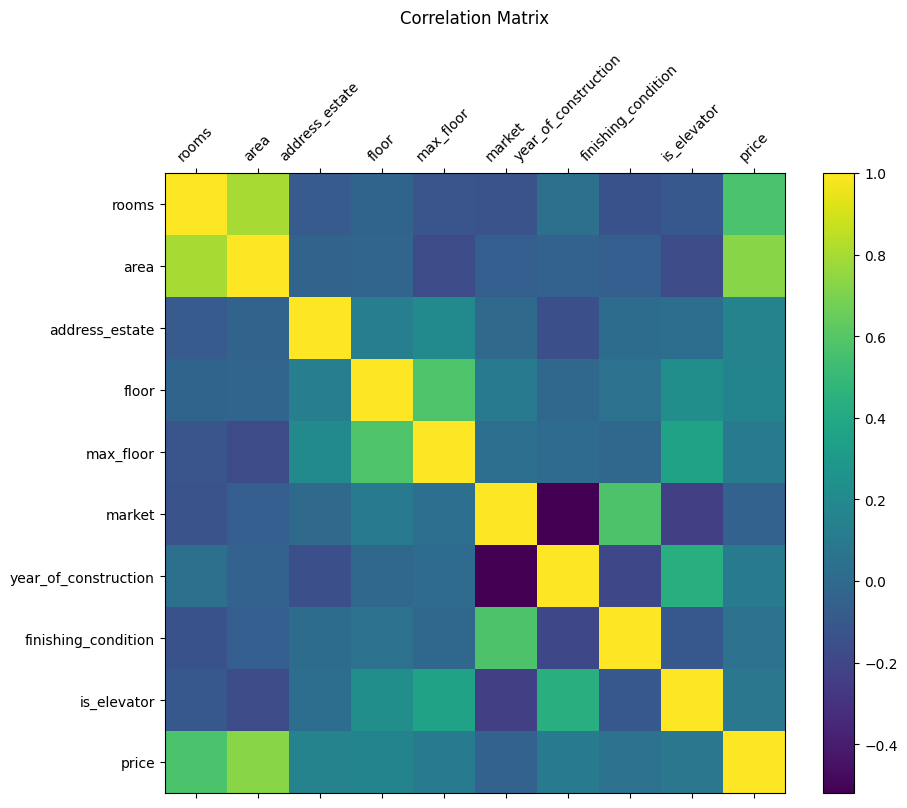

In [27]:
corr_matrix = data_cat.corr()
plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, fignum=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix', pad=20)
plt.savefig(out_plots_path / 'corelation_matrix.png', bbox_inches='tight')

### Robimy One Hot Encoding by pozbyć się korelacji między kategoriami

In [28]:
data_one_hot = pd.get_dummies(data_cat, columns=['finishing_condition', 'address_estate'])
print(data_one_hot)

      rooms   area  floor  max_floor  market  year_of_construction  \
0         2  39.19      2          7       1                  2024   
1         3  63.60      4         11       1                  1980   
2         2  50.00      3          4       1                  2015   
9         2  46.00      0          5       1                  1902   
10        3  46.03      5         11       1                  1968   
...     ...    ...    ...        ...     ...                   ...   
9837      3  71.90      0          1       0                  2023   
9839      3  70.60      3          6       0                  2024   
9840      2  42.20      0          2       0                  2025   
9841      2  60.00      1          4       1                  1910   
9842      3  63.82      0          4       0                  2023   

      is_elevator      price  finishing_condition_0  finishing_condition_1  \
0               1   569000.0                  False                   True   
1  

### Wyznaczamy X, y jako obiekty numpy

In [29]:
X = data_one_hot.drop(columns=[target]).to_numpy().astype(np.float32)
y = data_one_hot[target].to_numpy().astype(np.float32)
y = y/X[:, 1] # wezmy cene za metr kwadratowy
print(X[:10], y[:10], X.shape, y.shape)

[[2.000e+00 3.919e+01 2.000e+00 7.000e+00 1.000e+00 2.024e+03 1.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [3.000e+00 6.360e+01 4.000e+00 1.100e+01 1.000e+00 1.980e+03 1.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.000e+00 5.000e+01 3.000e+00 4.000e+00 1.000e+00 2.015e+03 1.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.000e+00 4.600e+01 0.000e+00 5.000e+00 1.000e+00 1.902e+03 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00]
 [3.000e+00 4.603e+01 5.000e+00 1.100e+01 1.000e+00 1.968e+03 1.000e+00
  1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [4.000e+00 6.6

podzial na zbiory

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_train, y_train)

In [32]:
# from sklearn.svm import SVC

# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [33]:
# results = []
# for c in param_grid['C']:
#   for gamma in param_grid['gamma']:
#     svc = SVC(C=c, gamma=gamma)
#     svc.fit(X_train, y_train)
#     results.append((svc.score(X_test, y_test)))
#     print(c, gamma)

In [34]:
# svc = sorted(results, key=lambda x: x[0])[-1][1]

In [35]:
# svc.score(X_test, y_test)

### Dzielimy zbiór na treningowy, walidacyjny i testowy

In [36]:
# us - unscaled
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X, y, test_size=.1, random_state=213)
X_train_us, X_val_us, y_train_us, y_val_us = train_test_split(X_train_us, y_train_us, test_size=.25, random_state=213)

In [37]:
print(X_train_us.shape, X_val_us.shape, X_test_us.shape)

(3034, 19) (1012, 19) (450, 19)


### Skalujemy dane do sredniej=0 + odchylenie std=1


In [38]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(X_train_us)

X_train = X_scaler.transform(X_train_us)
X_test = X_scaler.transform(X_test_us)
X_val = X_scaler.transform(X_val_us)

y_scaler = StandardScaler()
y_scaler.fit(y_train_us.reshape(-1, 1))

y_train = y_scaler.transform(y_train_us.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test_us.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val_us.reshape(-1, 1)).flatten()

In [39]:
print(y_train)

[ 0.6673373   0.537804    0.32459357 ... -0.40252933  0.5511721
 -0.32203534]


## Uczenie modeli

### Regresja liniowa i uogólniony model liniowy

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

model_lin = LinearRegression()
model_lin.fit(X_train, y_train)

# Przy wiekszych współczynnikach overfituje
model_GLM = LinearRegression()
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_GLM.fit(gen_features.fit_transform(X_train), y_train)

print(
    "Linear Regression MSE: ",
    mean_squared_error(model_lin.predict(X_train), y_train),
    mean_squared_error(model_lin.predict(X_val), y_val)
)

print(
    "Generalized Linear Model MSE: ",
    mean_squared_error(model_GLM.predict(gen_features.transform(X_train)), y_train),
    mean_squared_error(model_GLM.predict(gen_features.transform(X_val)), y_val)
)

Linear Regression MSE:  0.48928654 0.52235013
Generalized Linear Model MSE:  0.35247803 0.64072764


In [41]:
for i in range(10):
  print(
    y_scaler.inverse_transform(y_val[i].reshape(-1, 1)).flatten(),
    y_scaler.inverse_transform(model_lin.predict(X_val[i].reshape(1, -1))[0].reshape(-1, 1)).flatten()
  )

[12759.259] [13258.6]
[11550.] [10137.032]
[9375.] [11426.899]
[17374.88] [18020.896]
[13197.927] [12581.8955]
[12050.848] [12640.425]
[15114.286] [16442.22]
[19487.805] [15278.145]
[19521.86] [16334.812]
[14502.074] [14320.303]


### Policzmy średni błąd na realnej wartości odskalowanej

In [42]:
lin_diff_sum = 0
glm_diff_sum = 0
for i in range(len(y_val)):
  lin_diff_sum += np.abs(
    y_scaler.inverse_transform(y_val[i].reshape(-1, 1)).flatten()
    - y_scaler.inverse_transform(model_lin.predict(X_val[i].reshape(1, -1))[0].reshape(-1, 1)).flatten()
  )
  glm_diff_sum += np.abs(
    y_scaler.inverse_transform(y_val[i].reshape(-1, 1)).flatten()
    - y_scaler.inverse_transform(model_GLM.predict(gen_features.transform(X_val[i].reshape(1, -1)))[0].reshape(-1, 1)).flatten()
  )

print("lin:", lin_diff_sum/len(y_val) if len(y_val) > 0 else None)
print("glm:", glm_diff_sum/len(y_val) if len(y_val) > 0 else None)

lin: [1734.4354]
glm: [1557.0568]


### Sieć neuronowa (MLP)

Zamiana na tensor'y

In [43]:
X_train_t = torch.tensor(X_train)
X_test_t = torch.tensor(X_test)
X_val_t = torch.tensor(X_val)

y_train_t = torch.tensor(y_train)
y_test_t = torch.tensor(y_test)
y_val_t = torch.tensor(y_val)

Definicja architektury sieci

In [44]:
class Net(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.net = torch.nn.Sequential(
        torch.nn.Linear(19, 256),
        torch.nn.ReLU(),
        torch.nn.Dropout(.3),
        torch.nn.Linear(256, 128),
        torch.nn.ReLU(),
        torch.nn.Dropout(.3),
        torch.nn.Linear(128, 1),
      # torch.nn.Linear(10, 1)
    )

  def forward(self, x):
    # x.shape = (n_samples, m_features)
    return self.net(x)

Utworzenie obiektów pomocniczych

In [45]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

batch_size = 16 # po ile probek na raz których będzie srednia zamin bedzizemy uczyc
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # iterator do robienia batchy
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) # iterator do robienia batchy

### Uczenie modelu

In [91]:
net = Net()
lr = 0.001
n_epochs = 100 # ile razy 1 dataset bedziemy mielic przez siec

# uzywamy lepszego algorytmu do liczenia gradientu niz to co standardowo oferuje pytorch
optim = torch.optim.Adam(net.parameters(), lr=lr) 
loss = torch.nn.MSELoss()

for i in range(n_epochs):
  loss_sum = 0
  for inputs, targets in train_dataloader:

    outputs = net(inputs)
    l = loss(outputs.flatten(), targets)
    l.backward()
    with torch.no_grad():
      loss_sum += l*inputs.shape[0]
      # loss_sum += mean_squared_error(model_lin.predict(inputs), targets)
      optim.step()
      optim.zero_grad()

  with torch.no_grad():
    print(i, (
      loss_sum/X_train_t.shape[0]).item(), 
      loss(net(X_val_t).flatten(), y_val_t).item()
    )

0 0.5378408432006836 0.49150633811950684
1 0.4514387845993042 0.44400671124458313
2 0.42713162302970886 0.4294756352901459
3 0.4171099066734314 0.4295097589492798
4 0.4074770212173462 0.4161018133163452
5 0.39420270919799805 0.4098125398159027
6 0.38026151061058044 0.41176214814186096
7 0.36637187004089355 0.40228864550590515
8 0.3760986328125 0.3985809087753296
9 0.36289823055267334 0.3958882689476013
10 0.3564695715904236 0.37212249636650085
11 0.3506888151168823 0.3722030222415924
12 0.35055649280548096 0.38271382451057434
13 0.34785374999046326 0.3983563184738159
14 0.33869054913520813 0.3677026331424713
15 0.3313005864620209 0.38484758138656616
16 0.32122206687927246 0.3823539614677429
17 0.3240460157394409 0.38193151354789734
18 0.3179174065589905 0.39337044954299927
19 0.3191288411617279 0.3785059154033661
20 0.31378602981567383 0.37420812249183655
21 0.32271307706832886 0.3704501688480377
22 0.3183028995990753 0.3876305818557739
23 0.31846538186073303 0.36893564462661743
24 0.3

Wybieramy wyniki i 

In [82]:
net.eval()
print(loss(net(X_val_t).flatten(), y_val_t).item())

# detach - odłączamy od grafu obliczeń by nie liczyć gradientu i skonwertować do numpy
preds_unscaled = y_scaler.inverse_transform(net(X_val_t).detach().numpy()).flatten()
targets_unscaled = y_val_us # validation targets unscaled
print(mean_squared_error(preds_unscaled, y_val_us))

0.3566514253616333
4071273.8


In [83]:
print(preds_unscaled, targets_unscaled)

[12433.677 11537.116 11289.968 ... 24131.611 11952.586 15358.996] [12759.259 11550.     9375.    ... 25000.     8961.538 12195.893]


In [49]:
print(np.mean(np.abs(preds_unscaled - targets_unscaled)))
print(np.mean(np.abs(y_scaler.inverse_transform(model_lin.predict(X_val_t).reshape(-1, 1)).flatten() - targets_unscaled)))

1366.0007755037227
1734.4691912498608


In [50]:
print(np.mean(np.abs(preds_unscaled * X_val_us[:, 1]- targets_unscaled * X_val_us[:, 1])))
print(np.mean(np.abs(y_scaler.inverse_transform(model_lin.predict(X_val_t).reshape(-1, 1)).flatten()* X_val_us[:, 1] - targets_unscaled* X_val_us[:, 1])))

80868.23882903504
103545.80221713588


## Ocena i porównanie modeli

In [89]:
models = {
    'lin': lambda x: model_lin.predict(x),
    'glm': lambda x: model_GLM.predict(gen_features.transform(x)),
    'mlp': lambda x: net(torch.tensor(x)).detach().numpy()
}

In [90]:
def evaluate(models, X, y):
  for model_name, predict in models.items():
    error = np.mean(np.abs(
        y_scaler.inverse_transform(y.reshape(-1, 1)).flatten()
        - y_scaler.inverse_transform(predict(X).reshape(-1, 1)).flatten()
      ))
    print(f'{model_name}: {error}')

In [92]:
from functools import partial
evaluate_models = partial(evaluate, models)

In [94]:
print('Train')
evaluate_models(X_train, y_train)

print('\nValid')
evaluate_models(X_val, y_val)

print('\nTest')
evaluate_models(X_test, y_test)

Train
lin: 1693.7537841796875
glm: 1439.0933837890625
mlp: 1137.231201171875

Valid
lin: 1734.46923828125
glm: 1557.10693359375
mlp: 1347.9598388671875

Test
lin: 1762.2479248046875
glm: 1554.5216064453125
mlp: 1374.13525390625
